In [1]:
## Example month mean notebook CPOL

In [1]:
from dask_jobqueue import SLURMCluster
import dask.array as da
from dask import delayed
import pyart
import glob
from distributed import Client
%pylab inline
import pandas as pd
import dask.bag as db
import dask.array as da
from dask import delayed
from datetime import timedelta


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [47]:
def get_rainfall_rate(filename, level=3):
    grid = pyart.io.read_grid(filename, include_fields="radar_estimated_rain_rate")
    rr = grid.fields["radar_estimated_rain_rate"]["data"][level]
    del grid
    return rr.filled(0)

def get_mean_rr_rate_in_box(filename, level=3):
    grid = pyart.io.read_grid(filename, include_fields="radar_estimated_rain_rate")
    rr = grid.fields["radar_estimated_rain_rate"]["data"][level].filled(np.nan)
    x = grid.point_x["data"][level]
    y = grid.point_y["data"][level]
    # X range of box 1 -105000.0 47500.0
    # Y range of box 1 -122500.0 32500.0
    our_box = np.logical_and.reduce((x >= -105000., x <= 47500.0, y >= -122500., y <= 32500.))
    return np.nanmean(rr[our_box])

def get_file_time(filename):
    our_parts = filename.split("/")
    return datetime.datetime.strptime(our_parts[-1], "twp10cpolgrid150.b2.%Y%m%d.%H%M%S.nc")



In [17]:
client.map(get_extreme_event_counts, list_of_files[0:10])

KeyboardInterrupt: 

In [3]:
list_of_files = glob.glob('/lcrc/group/earthscience/rjackson/CPOL/grid_150km_2500m/**/*.nc', recursive=True)
list_of_files = sorted(list_of_files)
file_times = np.array([get_file_time(x) for x in list_of_files])

In [4]:
cluster = SLURMCluster(time='1:00:00', processes=6, cores=36, memory='128 GB', project='rainfall')
cluster.scale(24)

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/tornado/concurrent.py:521: DeprecationWarning: @return_future is deprecated, use coroutines instead
  DeprecationWarning)


In [5]:
client = Client(cluster)

In [245]:
client

Client Scheduler: tcp://140.221.70.5:44437 Dashboard: http://140.221.70.5:8787/status,Cluster Workers: 6 Cores: 36 Memory: 127.98 GB


In [241]:
cluster.scale(6)

In [11]:
dates = np.unique(np.array([x.date() for x in file_times]))
file_list = np.array(list_of_files)

In [9]:
file_times

array([datetime.datetime(1998, 12, 6, 6, 30),
       datetime.datetime(1998, 12, 6, 6, 40),
       datetime.datetime(1998, 12, 6, 6, 50), ...,
       datetime.datetime(2017, 5, 2, 0, 40),
       datetime.datetime(2017, 5, 2, 0, 50),
       datetime.datetime(2017, 5, 2, 1, 0)], dtype=object)

In [18]:
cluster.stop_all_jobs()

In [81]:
cluster.scale(8*36)

In [281]:
grid1 = pyart.io.read_grid(list_of_files[0])
x = grid1.point_x["data"][1]
y = grid1.point_y["data"][1]
rr = grid1.fields["radar_estimated_rain_rate"]["data"][1]
z = grid1.z["data"]
grid_lat = grid1.point_latitude["data"]
grid_lon = grid1.point_longitude["data"]

In [22]:
rr_rate = delayed(get_rainfall_rate)
rrs = [da.from_delayed(rr_rate(x), shape=rr.shape, dtype=float) for x in list_of_files]
rrs = da.stack(rrs)
rrs = da.nanmean(rrs, axis=0)

In [23]:
%time rrate = rrs.compute()

CPU times: user 2.85 s, sys: 612 ms, total: 3.47 s
Wall time: 17 s


Text(0.5,1,'Mean rain rate Apr 2006')

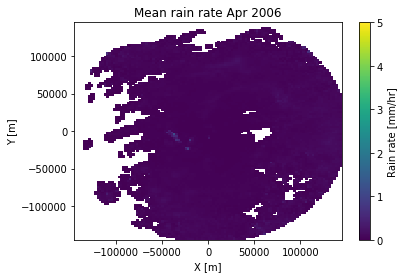

In [24]:
c= plt.pcolormesh(x, y, rrate, vmin=0, vmax=5)
plt.colorbar(c, label='Rain rate [mm/hr]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Mean rain rate Apr 2006')

Text(0,0.5,'Walltime [s]')

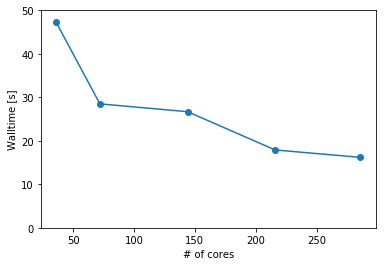

In [98]:
cores = [36, 72, 144, 216, 286]
seconds = [47.3, 28.5, 26.7, 17.9, 16.2]
plt.plot(cores, seconds, marker='o')
plt.ylim([0, 50])
plt.xlabel('# of cores')
plt.ylabel('Walltime [s]')

In [60]:
get_mean_rr_rate_in_box(list_of_files[0])

/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/common.py:98: UserWarning: Unexpected arguments: dict_keys(['include_fields'])
  warnings.warn('Unexpected arguments: %s' % dic.keys())


3.2223852

In [42]:
my_bag = db.from_sequence(list_of_files)

In [43]:
%time timeseries = np.array(my_bag.map(get_mean_rr_rate_in_box).compute())

CPU times: user 11min 6s, sys: 3min 4s, total: 14min 11s
Wall time: 23min 35s


In [63]:
# Create 3 hourly intervals from start time to end time
our_time_bins = np.array(pd.date_range(file_times.min(), file_times.max(), freq='3H').values)
print(our_time_bins)
ftimes_np64 = [np.datetime64(x) for x in file_times]
my_rr_array = np.zeros(len(our_time_bins))
for i in range(len(our_time_bins)):
    if i < len(our_time_bins)-1:
        ave_inds = np.where(np.logical_and(ftimes_np64 >= our_time_bins[i], ftimes_np64 < our_time_bins[i+1]))
    else:
        ave_inds = np.where(ftimes_np64 >= our_time_bins[i])
    my_rr_array[i] = np.nanmean(timeseries[ave_inds])

['1998-12-06T06:30:00.000000000' '1998-12-06T09:30:00.000000000'
 '1998-12-06T12:30:00.000000000' ... '2017-05-01T18:30:00.000000000'
 '2017-05-01T21:30:00.000000000' '2017-05-02T00:30:00.000000000']


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice


KeyboardInterrupt: 

In [45]:
my_df = pd.DataFrame({'time': ftimes_np64, 'rainfall_rate': timeseries})
my_df.to_csv('rainfall_.csv', na_rep="-9999.0")

In [294]:
my_df = pd.read_csv('rainfall_10min.csv')
my_df = my_df.replace(-9999., np.nan)
my_df = my_df.set_index(pd.DatetimeIndex(my_df["time"]))
my_df = my_df.resample('3H').mean()
sandros_range = pd.date_range(datetime.datetime(1998,1,1), datetime.datetime(2017, 12, 31, 21), freq='3H')
my_df = my_df.reindex(index=sandros_range)
my_df["rainfall_rate"]
my_df.to_csv('rainfall_3hr.csv')

In [295]:
my_df

,Unnamed: 0,rainfall_rate
1998-01-01 00:00:00,NaN,NaN
1998-01-01 03:00:00,NaN,NaN
1998-01-01 06:00:00,NaN,NaN
1998-01-01 09:00:00,NaN,NaN
1998-01-01 12:00:00,NaN,NaN
1998-01-01 15:00:00,NaN,NaN
1998-01-01 18:00:00,NaN,NaN
1998-01-01 21:00:00,NaN,NaN
1998-01-02 00:00:00,NaN,NaN
1998-01-02 03:00:00,NaN,NaN


In [3]:
def parse_array_file(the_file):
    fileptr = open(the_file)
    my_array = []
    for line in fileptr:
        my_line = line.strip("[")
        my_line = my_line.strip("[[")
        my_line = my_line.strip("\n")
        my_line = my_line.strip("]")
        pieces = my_line.split(' ')
        for the_piece in pieces:
            if the_piece == "[":
                continue
            if len(the_piece) > 0:
                my_array.append(float(the_piece))
    
    fileptr.close()
    return np.array(my_array)

In [4]:
sandros_rr_data = parse_array_file('z1500_20years.txt')
print(sandros_rr_data)

[nan nan nan ... nan nan nan]


In [120]:
sandros_rr_data = np.array([[  3.91665268e+00,   4.64748192e+00,   4.62208271e+00,   2.38778043e+00,
    9.15844202e-01,   6.85004056e-01,   1.49290180e+00,   9.71136749e-01],
 [  7.24617600e-01,   2.14274335e+00,   3.85146976e+00,   5.10213280e+00,
    3.67816424e+00,   2.84212995e+00,   8.01924646e-01,   4.57727015e-01],
 [  1.05067122e+00,   3.37936378e+00,   4.17552757e+00,   1.89552903e+00,
    3.52291894e+00,   2.52983785e+00,   9.77052391e-01,   2.68977427e+00],
 [  4.22394562e+00,   4.24921322e+00,   1.86232519e+00,   1.39031720e+00,
    2.12588596e+00,   1.73011780e+00,   1.07375276e+00,   6.58323586e-01],
 [  4.22742099e-01,   4.32646871e-01,   1.10758734e+00,   1.79825842e-01,
    1.75343525e+00,   5.83197927e+00,   5.67328453e+00,   1.45837617e+00],
 [  7.95290649e-01,   5.18046916e-01,   7.51848340e-01,   6.26050115e-01,
    4.64324147e-01,   1.19037829e-01,   9.26179290e-02,              nan],
 [             nan,              nan,              nan,   3.51445258e-01,
               nan,              nan,              nan,              nan],
 [             nan,              nan,              nan,   2.66205450e-03,
    4.86438900e-01,   6.72578633e-01,              nan,   1.01755238e+00],
 [             nan,              nan,              nan,   3.78109902e-01,
               nan,   4.60275918e-01,              nan,   5.93538815e-03],
 [             nan,   1.85632089e-03,              nan,              nan,
               nan,              nan,   1.60030961e+00,   1.21440542e+00],
 [             nan,              nan,              nan,   1.04895636e-01,
    2.37408816e-03,   2.42777184e-01,              nan,   9.19604599e-01],
 [             nan,   4.50775772e-01,   1.85134554e+00,   1.28262198e+00,
    6.08822203e+00,   4.33943176e+00,   3.54762697e+00,   1.82494628e+00],
 [  1.66797578e+00,   2.74142838e+00,   3.91025329e+00,   4.75270319e+00,
    5.59099388e+00,   1.70741546e+00,   5.69237828e-01,   5.55721391e-03],
 [  9.63882369e-04,   5.21837473e-01,   2.02534199e+00,   2.55276823e+00,
    2.81494522e+00,   8.24616373e-01,   9.26541805e-01,   2.81977113e-02],
 [  5.48624218e-01,   2.28603196e+00,   6.59921217e+00,   3.68412614e+00,
    1.59914696e+00,   1.82187065e-01,   5.53345978e-01,   5.22954583e-01],
 [  8.02516103e-01,              nan,              nan,              nan,
               nan,              nan,              nan,              nan],
 [             nan,   2.30130029e+00,   4.41961670e+00,   2.27292275e+00,
    3.70505154e-01,   3.36023659e-01,   2.63837636e-01,   5.42950397e-03],
 [  3.39581609e+00,   1.05623257e+00,   2.43939304e+00,   5.66655445e+00,
    2.15439463e+00,   4.33196127e-01,   9.98424888e-01,   1.16823471e+00],
 [  4.16639000e-01,   1.79630005e+00,   4.04856634e+00,   2.30573106e+00,
    4.30713326e-01,   9.12217140e-01,   3.70478439e+00,   4.13689280e+00],
 [  1.13838248e-01,   1.24435000e-01,              nan,   1.05333775e-02,
               nan,   9.81846679e-05,              nan,   2.38976837e-03],
 [             nan,              nan,              nan,   2.01916713e-02,
    1.27897561e-01,   2.38907233e-01,   2.92010754e-01,   2.91351408e-01],
 [             nan,              nan,              nan,   9.24569648e-03,
    1.10536911e-01,   2.52385467e-01,   2.75778860e-01,   2.54126061e-02],
 [  1.24922730e-01,   2.31734931e-01,   2.37431392e-01,   3.37567508e-01,
    2.50935286e-01,   3.35491627e-01,   4.32155728e-01,   7.88515806e-01],
 [  8.39973986e-01,   2.13256216e+00,   3.88756347e+00,   5.09488773e+00,
    3.63685608e+00,   2.17486835e+00,   1.59709167e+00,   1.25009394e+00],
 [  1.72675443e+00,   1.43741918e+00,   2.36839271e+00,   2.49820232e+00,
    2.57963181e+00,   4.89172268e+00,   4.76520586e+00,   3.69181919e+00],
 [  4.07333183e+00,   2.98970532e+00,   2.72780275e+00,   2.93972540e+00,
    3.33817184e-01,   5.67214847e-01,   5.43578863e-01,   1.41729510e+00],
 [  2.34883213e+00,   1.79069495e+00,   3.97342014e+00,   1.15014160e+00,
    8.67338085e+00,   3.51223850e+00,   2.59791780e+00,   8.13014805e-01],
 [  9.60304260e-01,   1.92170906e+00,   5.99950457e+00,   1.70590460e+00,
    1.40838817e-01,   8.36503685e-01,              nan,   9.86813474e-03],
 [  1.75739932e+00,   8.48619223e-01,   9.82558131e-01,   9.71817970e-03,
               nan,              nan,              nan,   1.19830377e-03]])

[0.01786074 0.01808849 0.016674   0.05849615 0.0151326  0.01788851
 0.0170907  0.01789264 0.02004927 0.02230618 0.04111263 0.01737049
 0.02435079 0.02515235 0.02004326 0.02387906 0.02208393 0.02657882
 0.01750834 0.01525126 0.02509956 0.02233429 0.03455648 0.04246537
 0.03555625 0.04269715 0.03986252 0.03785994 0.03824041 0.040312
 0.03842583 0.04332567 0.04508537 0.05311592 0.0458858  0.04677401
 0.0443601  0.04518434 0.05039102 0.04245852 0.04212959 0.03510759
 0.02962256 0.02571207 0.04679501 0.02153689 0.01825118 0.01655001
 0.01516961 0.01725874 0.01496102 0.01622566 0.01738678 0.01905932
 0.0151813  0.02039496 0.01543459 0.01476596 0.01934335 0.02481583
 0.02401832 0.03353071 0.0504804  0.05073846 0.05505821 0.05053988
 0.05045907 0.0491861  0.05185104 0.04271694 0.04267354 0.04154699
 0.04067568 0.03494731 0.03387207 0.03141293 0.03106485 0.03232834
 0.03329436 0.03029187 0.03061721 0.02969735 0.02541017 0.02276342
 0.01787357 0.01998272 0.03057961 0.0318953  0.02856928 0.026999

Text(0,0.5,'rain rate [mm/hr]')

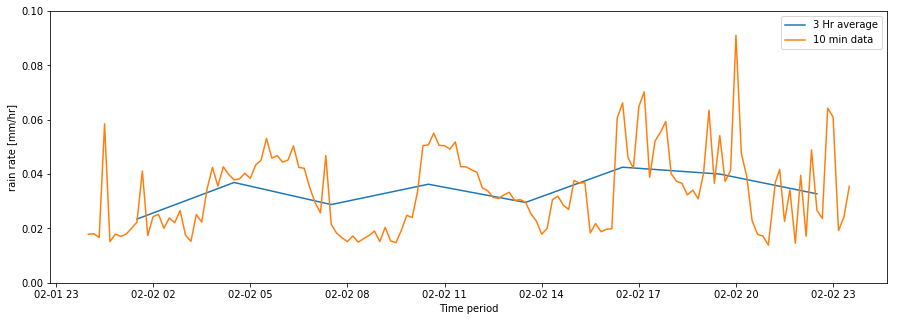

In [55]:
plt.figure(figsize=(15,5))
plt.plot(our_time_bins+np.timedelta64(1, 'h')+np.timedelta64(30, 'm'), my_rr_array, label='3 Hr average')
plt.plot(file_times, timeseries, label="10 min data")
#plt.plot(sandros_rr_data.flatten(), label='Sandros data')
plt.legend()
plt.ylim([0, 0.10])
print(timeseries)
plt.xlabel('Time period')
plt.ylabel('rain rate [mm/hr]')

In [117]:
print(my_rr_array)

[3.71276188e+00 4.50343752e+00 4.50051451e+00 2.32730484e+00
 8.90567899e-01 6.51203036e-01 1.42330241e+00 9.46957886e-01
 6.44336283e-01 2.01870751e+00 3.70300841e+00 4.89331055e+00
 3.52294230e+00 2.73121476e+00 7.87627220e-01 4.57360804e-01
 9.50701058e-01 3.20251131e+00 4.03768921e+00 1.82832801e+00
 3.37584567e+00 2.40734911e+00 9.39436257e-01 2.58721423e+00
 4.06392479e+00 4.06447792e+00 1.80071449e+00 1.42555666e+00
 2.15641975e+00 1.72839904e+00 1.09370661e+00 7.13633060e-01
 4.31817859e-01 3.62832755e-01 1.06118035e+00 1.65068105e-01
 1.67668080e+00 5.68954992e+00 5.46324062e+00 1.44084847e+00
 7.36376286e-01 4.69632417e-01 6.81298375e-01 5.77314138e-01
 4.42909986e-01 1.07952721e-01 9.02306661e-02            nan
            nan            nan            nan 3.37527752e-01
            nan            nan            nan            nan
            nan            nan            nan 2.50804587e-03
 5.07562041e-01 6.77771688e-01            nan 9.75745738e-01
            nan         

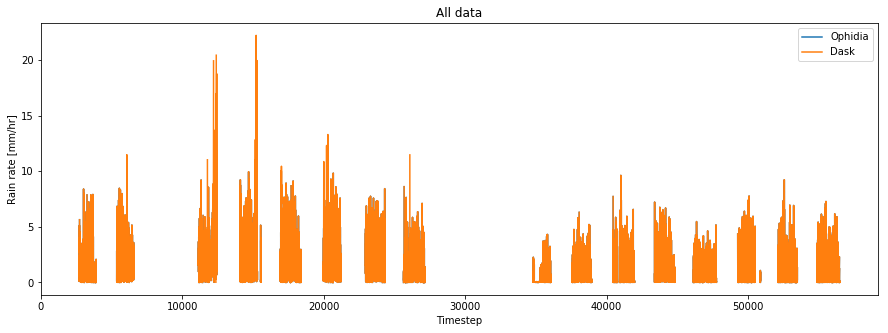

In [14]:
my_df = my_df.replace(-9999., np.nan)
fig = plt.figure(figsize=(15,5))
plt.plot(sandros_rr_data, label='Ophidia')
plt.plot(my_df["rainfall_rate"].values, label='Dask')
plt.xlabel('Timestep')
plt.ylabel('Rain rate [mm/hr]')
plt.title('All data')
plt.legend()
fig.savefig('all_timeseries.png', dpi=300)

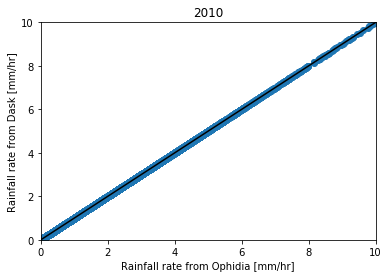

In [11]:
plt.scatter(sandros_rr_data, my_df["rainfall_rate"])
plt.plot([0, 10], [0, 10], 'k')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.xlabel('Rainfall rate from Ophidia [mm/hr]')
plt.ylabel('Rainfall rate from Dask [mm/hr]')
plt.title('2010')
plt.savefig('all_comparison.png', dpi=300)

In [18]:
years = np.array([x.year for x in file_times])
hours = np.array([x.hour for x in file_times])
my_inds = np.where(years == 1998)[0].astype(int)

In [19]:
list_of_files_red = list_of_files[my_inds[0]:my_inds[-1]]
list_of_files_red

['/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0630_GRIDS_2500m.nc',
 '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0640_GRIDS_2500m.nc',
 '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0650_GRIDS_2500m.nc',
 '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0700_GRIDS_2500m.nc',
 '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0710_GRIDS_2500m.nc',
 '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0720_GRIDS_2500m.nc',
 '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0730_GRIDS_2500m.nc',
 '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/1998/19981206/CPOL_19981206_0740_GRIDS_2500m.nc',
 '/lcrc/group/earthscien

In [20]:
my_bag = db.from_sequence(list_of_files_red)

In [21]:
%time timeseries = np.stack(my_bag.map(get_rainfall_rate).compute())

CPU times: user 3.49 s, sys: 887 ms, total: 4.38 s
Wall time: 39 s


In [22]:
tsum = np.nansum(timeseries, axis=0)
tcount = np.isfinite(timeseries).sum(axis=0)
print(tcount)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


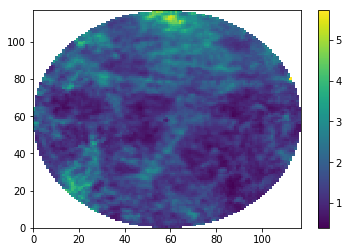

In [23]:
plt.pcolormesh(tsum/tcount)
plt.colorbar()


In [24]:
np.savez('sumcount1998.npz', tsum, tcount)

<input>:10: DeprecationWarning: invalid escape sequence \l
<input>:11: DeprecationWarning: invalid escape sequence \d
<input>:10: DeprecationWarning: invalid escape sequence \l
<input>:11: DeprecationWarning: invalid escape sequence \d
<input>:10: DeprecationWarning: invalid escape sequence \l
<input>:11: DeprecationWarning: invalid escape sequence \d
<ipython-input-25-bc228399944f>:10: DeprecationWarning: invalid escape sequence \l
  ax[int(i/6), i % 6].set_xlabel('Longitude [$\longitude$]')
<ipython-input-25-bc228399944f>:11: DeprecationWarning: invalid escape sequence \d
  ax[int(i/6), i % 6].set_ylabel('Latitude [$\degree$]')
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


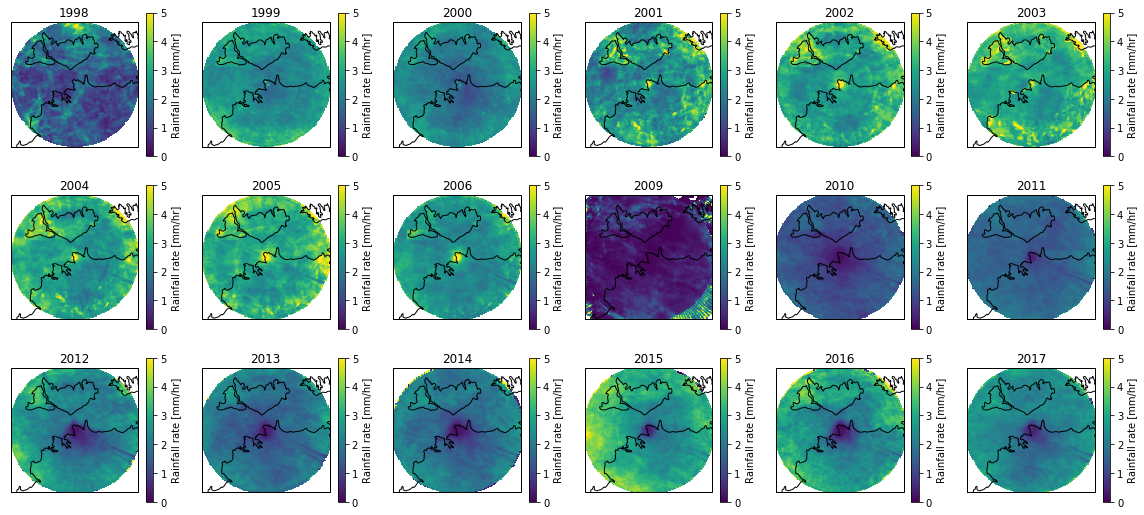

In [25]:
import cartopy.crs as ccrs
years = ['1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2009', '2010', '2011', '2012', '2013',
         '2014', '2015', '2016', '2017']
i = 0

fig, ax = plt.subplots(3, 6, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 9))
for y in years:
    data = np.load('sumcount' + y + '.npz')
    h = ax[int(i/6), i % 6].pcolormesh(grid_lon[0], grid_lat[0], data['arr_0']/data['arr_1'], vmin=0, vmax=5)
    ax[int(i/6), i % 6].set_xlabel('Longitude [$\longitude$]')
    ax[int(i/6), i % 6].set_ylabel('Latitude [$\degree$]')
    ax[int(i/6), i % 6].coastlines(resolution='10m')
    plt.colorbar(h, ax=ax[int(i/6), i % 6], label='Rainfall rate [mm/hr]')
    ax[int(i/6), i % 6].set_title(y)
    i = i + 1
fig.savefig('allpanels.png', dpi=300)

<input>:17: DeprecationWarning: invalid escape sequence \l
<input>:18: DeprecationWarning: invalid escape sequence \d
<input>:17: DeprecationWarning: invalid escape sequence \l
<input>:18: DeprecationWarning: invalid escape sequence \d
<input>:17: DeprecationWarning: invalid escape sequence \l
<input>:18: DeprecationWarning: invalid escape sequence \d
<ipython-input-31-15e697237d1b>:17: DeprecationWarning: invalid escape sequence \l
  ax[j].set_xlabel('Longitude [$\longitude$]')
<ipython-input-31-15e697237d1b>:18: DeprecationWarning: invalid escape sequence \d
  ax[j].set_ylabel('Latitude [$\degree$]')
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


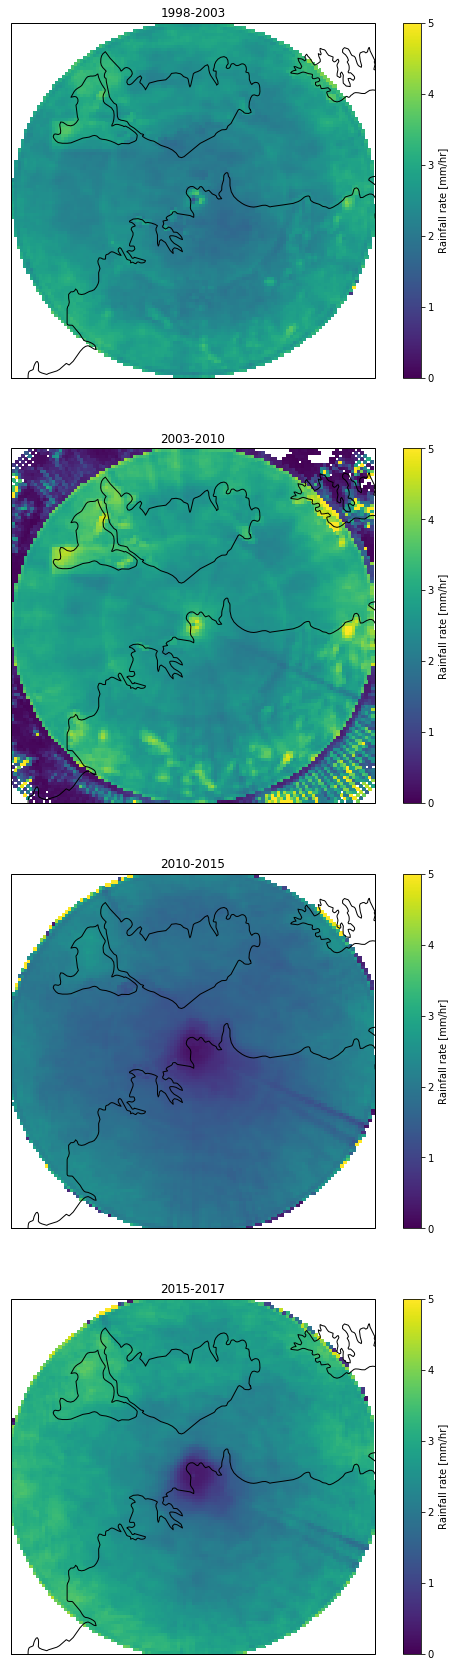

In [31]:
year_interval = 5
fig, ax = plt.subplots(int(20/year_interval), 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 30))
j = 0

for y in range(0, len(years), year_interval):
    tsum = None
    tnumber = None
    for i in range(y, min(y+year_interval, len(years))):
        data = np.load('sumcount' + years[i] + '.npz')
        if tsum is None:
            tsum = data['arr_0']
            tcount = data['arr_1']
        else:
            tsum += data['arr_0']
            tcount += data['arr_1']
    h = ax[j].pcolormesh(grid_lon[0], grid_lat[0], tsum/tcount, vmin=0, vmax=5)
    ax[j].set_xlabel('Longitude [$\longitude$]')
    ax[j].set_ylabel('Latitude [$\degree$]')
    ax[j].coastlines(resolution='10m')
    plt.colorbar(h, ax=ax[j], label='Rainfall rate [mm/hr]')
    ax[j].set_title(years[y] + '-' + years[min(y+year_interval, len(years)-1)])
    j = j + 1
fig.savefig('totalrain.png', dpi=300)

<input>:17: DeprecationWarning: invalid escape sequence \l
<input>:18: DeprecationWarning: invalid escape sequence \d
<input>:17: DeprecationWarning: invalid escape sequence \l
<input>:18: DeprecationWarning: invalid escape sequence \d
<input>:17: DeprecationWarning: invalid escape sequence \l
<input>:18: DeprecationWarning: invalid escape sequence \d
<ipython-input-32-d66412737b24>:17: DeprecationWarning: invalid escape sequence \l
  ax[j].set_xlabel('Longitude [$\longitude$]')
<ipython-input-32-d66412737b24>:18: DeprecationWarning: invalid escape sequence \d
  ax[j].set_ylabel('Latitude [$\degree$]')
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/sit

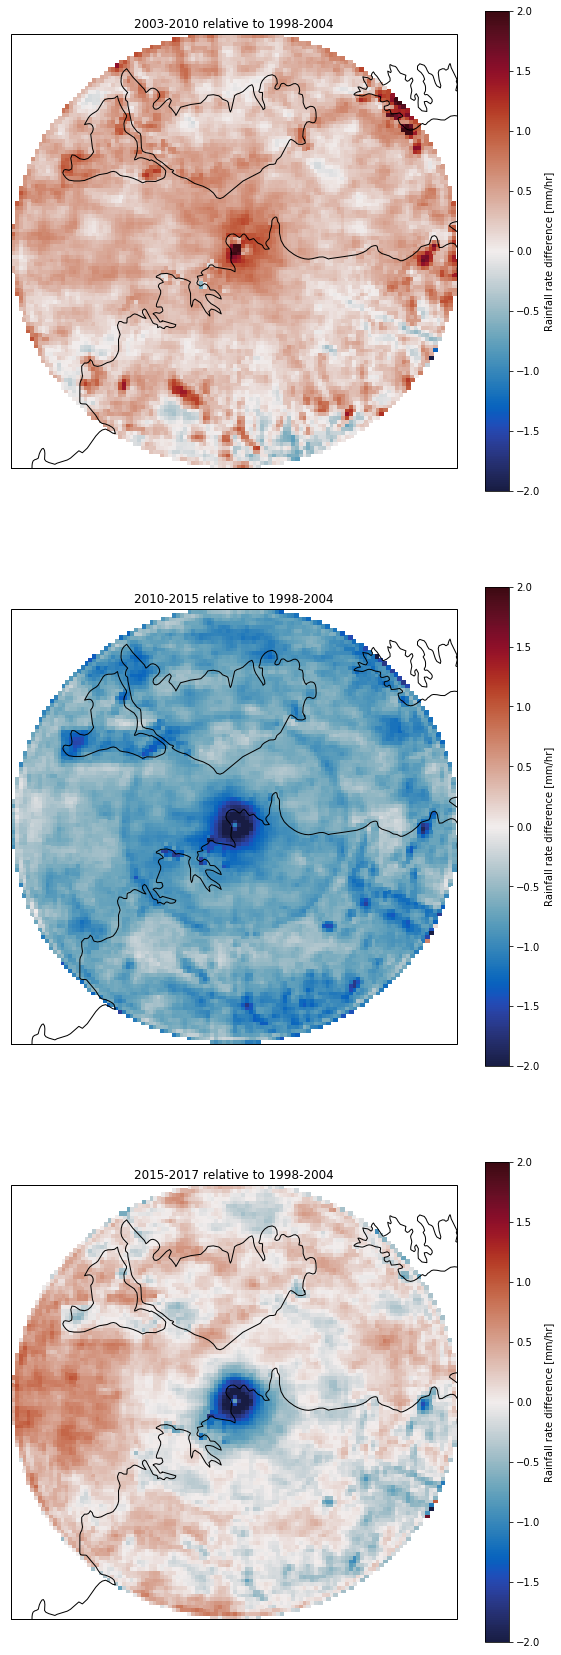

In [32]:
year_interval = 5
fig, ax = plt.subplots(int(20/year_interval)-1, 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 30))
j = 0
for y in range(0, len(years), year_interval):
    tsum = None
    tnumber = None
    for i in range(y, min(y+year_interval, len(years))):
        data = np.load('sumcount' + years[i] + '.npz')
        if tsum is None:
            tsum = data['arr_0']
            tcount = data['arr_1']
        else:
            tsum += data['arr_0']
            tcount += data['arr_1']
    if y > 0:
        h = ax[j].pcolormesh(grid_lon[0], grid_lat[0], tsum/tcount-mean_old, vmin=-2, vmax=2, cmap='pyart_balance')
        ax[j].set_xlabel('Longitude [$\longitude$]')
        ax[j].set_ylabel('Latitude [$\degree$]')
        ax[j].coastlines(resolution='10m')
        plt.colorbar(h, ax=ax[j], label='Rainfall rate difference [mm/hr]')
        ax[j].set_title(years[y] + '-' + years[min(y+year_interval, len(years)-1)]+ ' relative to 1998-2004')
        j = j + 1
    else:
        mean_old = tsum/tcount     
fig.savefig('5yearrain_diff.png', dpi=300)

In [59]:
rr = get_rainfall_rate(file_list[0])
my_shape = rr.shape

def get_extreme_event_counts(date, threshold=20.0):
    my_inds = np.where(dates == date)[0]
    files = file_list[my_inds]
    if len(my_inds) == 0:
        return []
    rr_rate = delayed(get_rainfall_rate)
    rrs = [da.from_delayed(rr_rate(x), shape=my_shape, dtype=float) for x in files]
    rrs = da.sum(da.stack(rrs, axis=0), axis=0).compute()
    rrs = rrs/6.0
    return rrs

/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/common.py:98: UserWarning: Unexpected arguments: dict_keys(['include_fields'])
  warnings.warn('Unexpected arguments: %s' % dic.keys())


In [60]:
years = np.array([x.year for x in dates])

In [201]:
year = 2017
my_dates = dates[years == year]
array_list = [get_extreme_event_counts(x) for x in my_dates]

In [202]:
import xarray as xr

xr_dates = np.array([np.datetime64(x) for x in my_dates])
my_ds = xr.Dataset({'accums': (('time', 'x', 'y'), np.stack(array_list, axis=0)), 
                    'time': (('time',), xr_dates)})
my_ds.to_netcdf(('accums%d.nc' % year))

In [203]:
my_ds

<xarray.Dataset>
Dimensions:  (time: 122, x: 117, y: 117)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 2017-01-03 ...
Dimensions without coordinates: x, y
Data variables:
    accums   (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [28]:
get_extreme_event_counts(dates[0])

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [204]:
my_daily_accumulations = xr.open_mfdataset('accums*.nc', parallel=False)

In [287]:
extremes = xr.where(my_daily_accumulations['accums'] > 5., 1, 0)
extremes.sel(time='2000')

<xarray.DataArray 'accums' (time: 91, x: 117, y: 117)>
dask.array<shape=(91, 117, 117), dtype=int64, chunksize=(91, 117, 117)>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
Dimensions without coordinates: x, y

<input>:10: DeprecationWarning: invalid escape sequence \l
<input>:11: DeprecationWarning: invalid escape sequence \d
<input>:10: DeprecationWarning: invalid escape sequence \l
<input>:11: DeprecationWarning: invalid escape sequence \d
<input>:10: DeprecationWarning: invalid escape sequence \l
<input>:11: DeprecationWarning: invalid escape sequence \d
<ipython-input-293-01dba7485f1b>:10: DeprecationWarning: invalid escape sequence \l
  ax[int(i/6), i % 6].set_xlabel('Longitude [$\longitude$]')
<ipython-input-293-01dba7485f1b>:11: DeprecationWarning: invalid escape sequence \d
  ax[int(i/6), i % 6].set_ylabel('Latitude [$\degree$]')


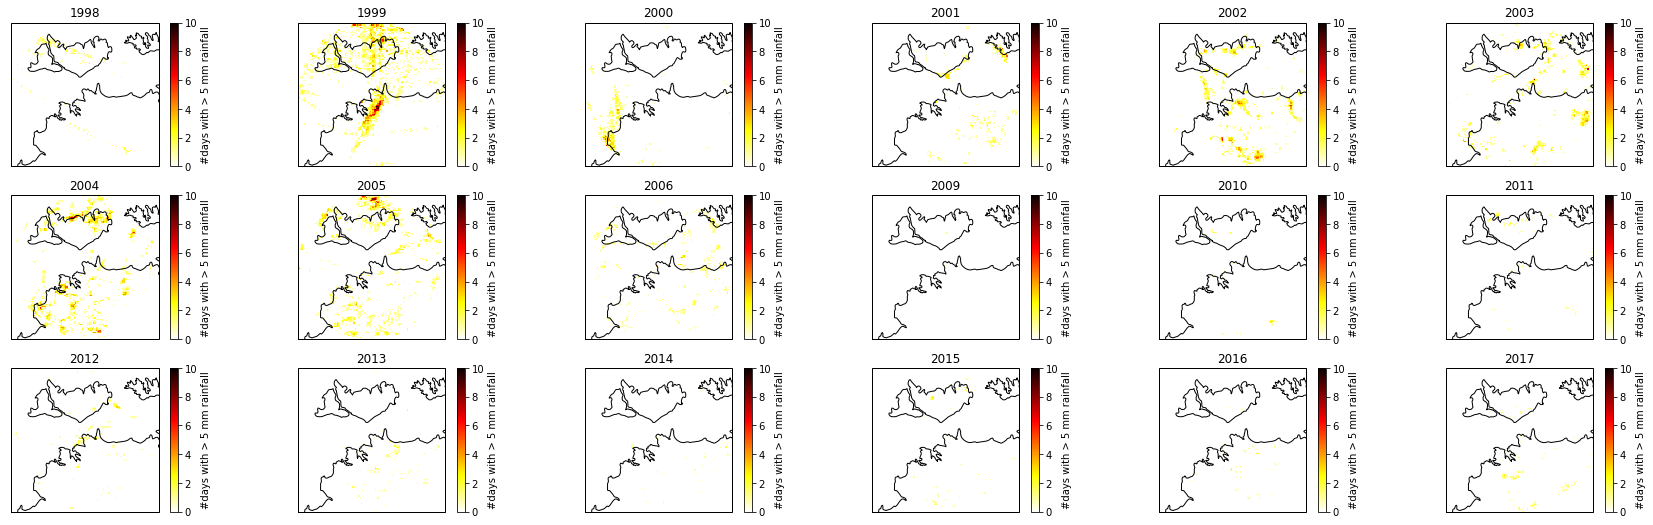

In [293]:
import cartopy.crs as ccrs
years = ['1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2009', '2010', '2011', '2012', '2013',
         '2014', '2015', '2016', '2017']
i = 0

fig, ax = plt.subplots(3, 6, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(30, 9))
for y in years:
    data = extremes.sel(time=y).sum(axis=0).values
    h = ax[int(i/6), i % 6].pcolormesh(grid_lon[0], grid_lat[0], data, vmin=0, vmax=10, cmap='hot_r')
    ax[int(i/6), i % 6].set_xlabel('Longitude [$\longitude$]')
    ax[int(i/6), i % 6].set_ylabel('Latitude [$\degree$]')
    ax[int(i/6), i % 6].coastlines(resolution='10m')
    plt.colorbar(h, ax=ax[int(i/6), i % 6], label='#days with > 5 mm rainfall')
    ax[int(i/6), i % 6].set_title(y)
    i = i + 1
fig.savefig('allpanels_extremes.png', dpi=300)

In [267]:
my_daily_accumulations['accums'].isel(time=0).where(my_daily_accumulations.accums > 1, 0, 1, drop=False).plot()

TypeError: where() got multiple values for argument 'drop'

In [149]:
my_daily_accumulations.close()

In [325]:
my_df = pd.read_csv('rainfall_10min.csv')
my_df = my_df.replace(-9999., np.nan)
my_df = my_df.set_index(pd.DatetimeIndex(my_df["time"]))
my_df = my_df.resample('3H').sum()/6.
sandros_range = pd.date_range(datetime.datetime(1998,1,1), datetime.datetime(2017, 12, 31, 21), freq='3H')
my_df = my_df.reindex(index=sandros_range)

In [327]:
years = np.array([x.year for x in sandros_range])

In [345]:
my_bins = np.logspace(-1, 2, 100)
year_bins = np.unique(years)
my_hist = np.zeros((len(my_bins)-1, len(year_bins)))
for i in range(len(year_bins)):
    my_inds = np.where(np.logical_and(years == year_bins[i], my_df['rainfall_rate'].values > 0))
    hist, bins = np.histogram(my_df['rainfall_rate'].values[my_inds], normed=False, bins=my_bins)
    my_hist[:, i] = hist

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Passing normed=False is deprecated, and has no

Text(0,0.5,'3 hour rainfall accumulation [mm]')

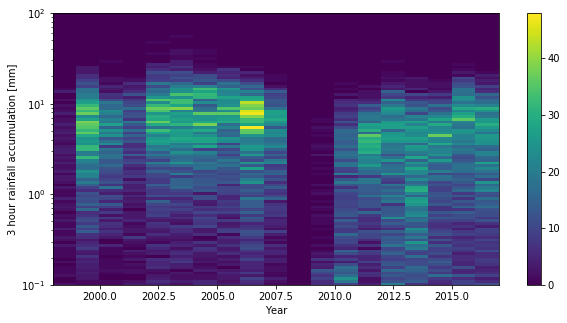

In [348]:
x, y = np.meshgrid(year_bins, my_bins)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
mesh= ax.pcolormesh(x, y,my_hist)
plt.colorbar(mesh, ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Year')
ax.set_ylabel('3 hour rainfall accumulation [mm]')

In [331]:
my_df['rainfall_rate'].values[300]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])